# On Analyzing Real World Time Series for Forecasting: Bitcoin Price Dataset (2017-2023)

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

# from collections import namedtuple
from data_loader import build_bitcoin_uts

from ts_models import RandomWalk, AR, ARMA, ARIMA_model, EvaluationMetric
# from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Initialize & Predict Random Walk Model on Raw Data
    1. Split Raw Data
7. Difference
8. Get Descriptive Statistics (ie: mean, median, etc)
9. Check Stationarity of Differenced Data
10. Plot Autocorrelation and Partial Autocorrelation of Differenced Data
11. Initialize & Predict Random Walk `RW` Model on Raw Data
    1. Split Differenced Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
15. Follow-up

### Load Raw Data

In [2]:
reversed_bitcoin_ts = build_bitcoin_uts()

In [3]:
reversed_bitcoin_df = reversed_bitcoin_ts.get_as_df()
reversed_bitcoin_df

,close
Timestamp,
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28902.49
2023-08-01,28908.53
2023-08-01,28907.41
...,...
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56


In [4]:
bitcoin_ts = reversed_bitcoin_ts.data_augment_reverse()
bitcoin_ts

UnivariateTimeSeries(close)

In [5]:
bitcoin_df = bitcoin_ts.get_as_df()
bitcoin_df

,close
Timestamp,
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


### Plot Raw Data

- August 2017 to July 2023. The data has been meticulously collected from the Binance API, with price data captured at **one-minute intervals** [About Dataset](https://www.kaggle.com/datasets/jkraak/bitcoin-price-dataset)

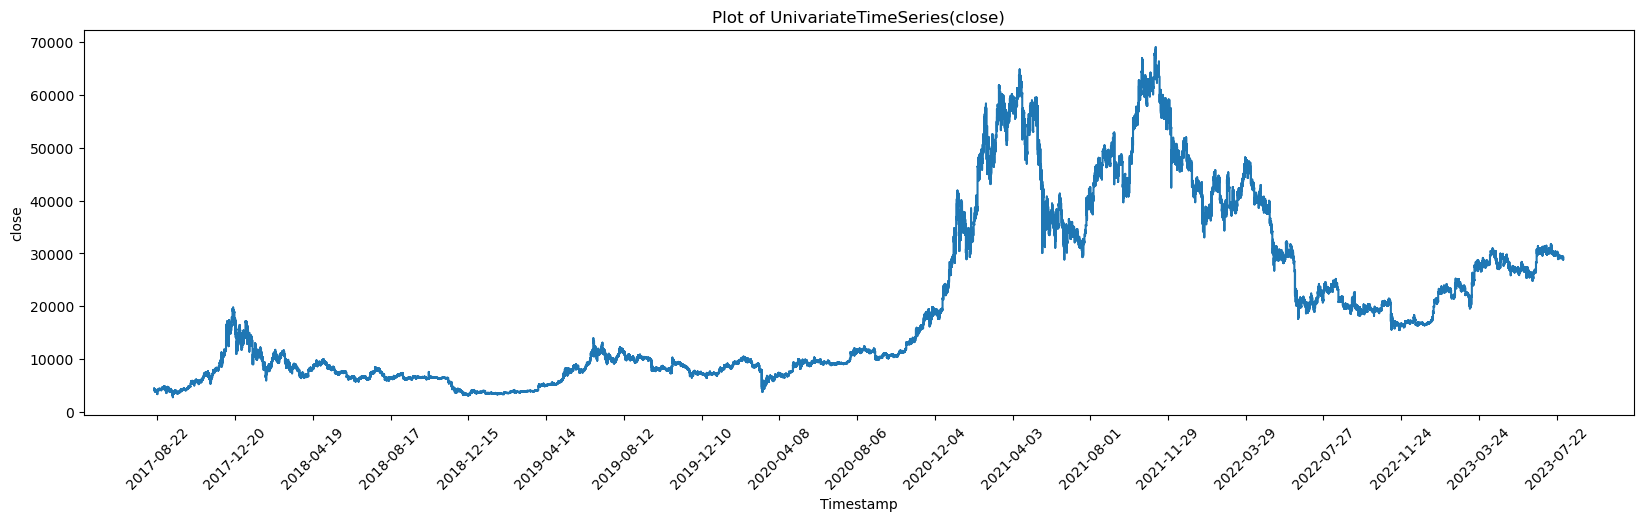

In [6]:
bitcoin_ts.plot(tick_skip=120)

### Get Descriptive Statistics of Raw Data

In [7]:
bitcoin_ts.get_statistics()

,close
count,3.126000e+06
mean,2.008946e+04
std,1.605896e+04
min,2.817000e+03
25%,7.624798e+03
50%,1.170000e+04
75%,2.989957e+04
max,6.900000e+04


In [8]:
bitcoin_ts.range_skewness_kurtosis()

{'Range': close    66183.0
 dtype: float64,
 'Skewness': close    1.029161
 dtype: float64,
 'Kurtosis': close   -0.056707
 dtype: float64}

### Check Stationarity of Raw Data

In [9]:
# both a taking a while
# bitcoin_ts.stationarity_test(bitcoin_df)

# from statsmodels.tsa.stattools import adfuller, bds

# adfuller(bitcoin_df)

- Stationarity test is taking a while. From looking at the graph, we can see that the time series is NOT stationary, so we can difference.

In [10]:
# bitcoin_series = bitcoin_ts.get_series()
# bitcoin_ts.independence_test(bitcoin_series)

- Independence test is taking a while as well. Assume that the data is dependent as there is correlation due to the time series being non-stationary.

### Initialize & Predict (RW) Model of Raw Data
- RW uses the raw data because the current observation depends on the previous, thus dependency is need and dependency is in raw data. Differencing removes this dependence.

In [11]:
bitcoin_series = bitcoin_ts.get_series()
bitcoin_series

array([ 4261.48,  4261.48,  4280.56, ..., 28902.49, 28902.49, 28902.49])

In [12]:
day_forecast = 60 * 24
year_forecast = day_forecast * 365
forecasting_step = year_forecast
N = len(bitcoin_ts.get_series())
train_length = N - forecasting_step
train_length

2600400

In [13]:
train_uts, test_uts = bitcoin_ts.get_slice(1, train_length, both_train_test=True)
train_uts, test_uts

1 2600400


(UnivariateTimeSeries(UnivariateTimeSeries(close)[1:2600400]),
 UnivariateTimeSeries(UnivariateTimeSeries(close)[2600400:3126000]))

In [14]:
train_df = train_uts.get_as_df()
train_df

,UnivariateTimeSeries(close)[1:2600400]
Timestamp,
2017-08-17,4261.48
2017-08-17,4280.56
2017-08-17,4261.48
2017-08-17,4261.48
2017-08-17,4261.48
...,...
2022-08-01,22932.67
2022-08-01,22938.14
2022-08-01,22947.96


In [15]:
test_df = test_uts.get_as_df()
test_df

,UnivariateTimeSeries(close)[2600400:3126000]
Timestamp,
2022-08-01,22941.82
2022-08-01,22914.89
2022-08-01,22936.11
2022-08-01,22886.88
2022-08-01,22873.86
...,...
2023-08-01,28907.41
2023-08-01,28908.53
2023-08-01,28902.49


In [16]:
rw_model_class = RandomWalk()

rw_predictions = rw_model_class.predict(train_df, test_df)

In [17]:
type(rw_predictions[0]), len(rw_predictions), rw_predictions

(numpy.ndarray,
 525600,
 [array([22943.94]),
  array([22941.82]),
  array([22914.89]),
  array([22936.11]),
  array([22886.88]),
  array([22873.86]),
  array([22902.11]),
  array([22869.44]),
  array([22864.83]),
  array([22872.37]),
  array([22890.63]),
  array([22875.19]),
  array([22883.85]),
  array([22894.23]),
  array([22916.73]),
  array([22921.51]),
  array([22931.97]),
  array([22935.4]),
  array([22952.85]),
  array([22968.46]),
  array([22953.36]),
  array([22929.78]),
  array([22940.97]),
  array([22943.88]),
  array([22922.16]),
  array([22909.76]),
  array([22925.09]),
  array([22925.98]),
  array([22947.69]),
  array([22954.67]),
  array([22989.03]),
  array([22981.01]),
  array([22962.11]),
  array([22970.]),
  array([22970.93]),
  array([22987.91]),
  array([22994.45]),
  array([23017.49]),
  array([23017.73]),
  array([22997.74]),
  array([22982.64]),
  array([22985.25]),
  array([22976.87]),
  array([22982.42]),
  array([22987.23]),
  array([22953.14]),
  array([229

In [18]:
rw_mse_gsts = EvaluationMetric.eval_mse(test_df, rw_predictions, per_element=False)
rw_rmse_gsts = EvaluationMetric.eval_rmse(test_df, rw_predictions, per_element=False)

Test MSE: 234.540
Test RMSE: 15.315


- Both `MSE` and `RMSE` for the raw TS are high. Why?

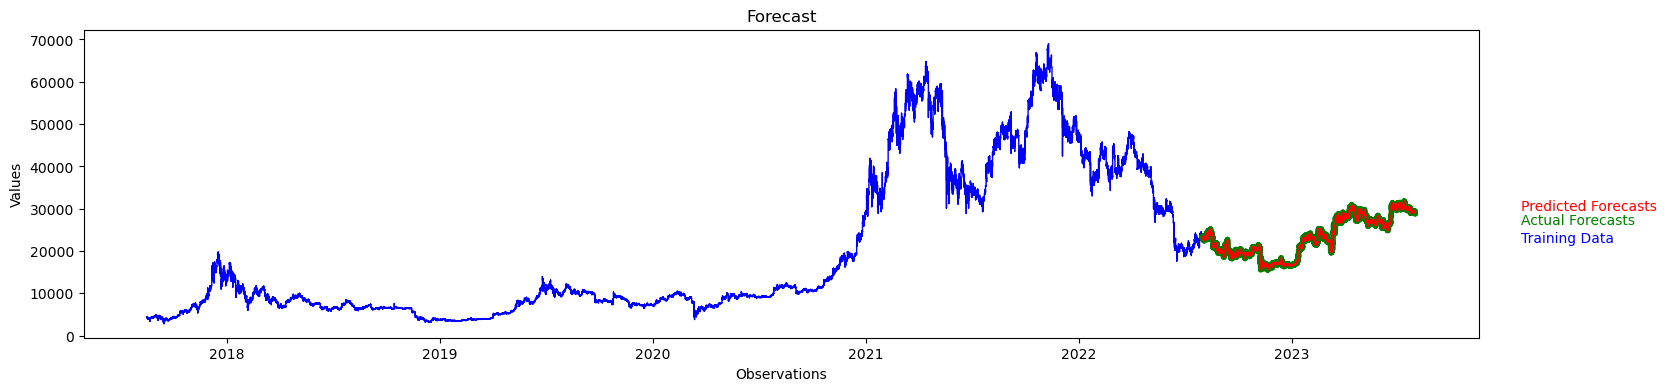

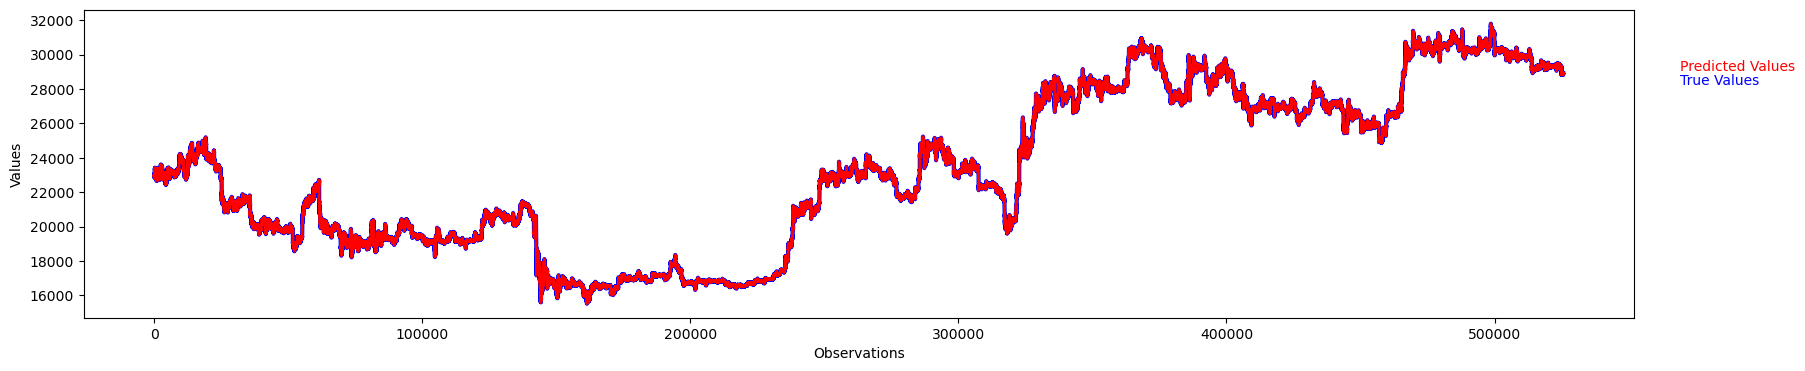

In [19]:
EvaluationMetric.plot_forecast(train_df, test_df, rw_predictions, per_element=False)
# EvaluationMetric.plot_forecast_only(test_df, rw_predictions, per_element=True)
# EvaluationMetric.plot_forecast_only(test_df, rw_predictions)

EvaluationMetric.plot_predictions(test_df, rw_predictions)

### Initialize & Predict ARIMA Model of Raw Data
- ARIMA assumes non-stationarity

In [20]:
lag_p = 1 
integrated_d = 1
error_q = 1
arima_model_class = ARIMA_model()
arima_model = arima_model_class.train_arima_model(train_df, lag_p, integrated_d, error_q)


/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
# retrain false
arima_predictions_no_retrain = arima_model_class.predict(arima_model, train_df, test_df, False, lag_p)

# retrain true
arima_predictions_retrain = arima_model_class.predict(arima_model, train_df, test_df, True, lag_p)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
arima_predictions_no_retrain

2600399    22944.164003
2600400    22944.051715
2600401    22944.108003
2600402    22944.079787
2600403    22944.093931
               ...     
3125994    22944.089208
3125995    22944.089208
3125996    22944.089208
3125997    22944.089208
3125998    22944.089208
Name: predicted_mean, Length: 525600, dtype: float64

In [23]:
arima_predictions_retrain

[array([11847.08596659]),
 array([11845.99125989]),
 array([11832.0853865]),
 array([11843.04278098]),
 array([11817.62183235]),
 array([11810.89868079]),
 array([11825.48616401]),
 array([11808.61632059]),
 array([11806.23584987]),
 array([11810.12928787]),
 array([11819.55822393]),
 array([11811.58545434]),
 array([11816.05722795]),
 array([11821.41715984]),
 array([11833.0355093]),
 array([11835.5037631]),
 array([11840.90500468]),
 array([11842.6761575]),
 array([11851.68683298]),
 array([11859.74738565]),
 array([11851.95018223]),
 array([11839.77415199]),
 array([11845.55234446]),
 array([11847.05498433]),
 array([11835.83940431]),
 array([11829.43640283]),
 array([11837.35237159]),
 array([11837.81194186]),
 array([11849.02235817]),
 array([11852.62662836]),
 array([11870.36913892]),
 array([11866.2278428]),
 array([11856.46842925]),
 array([11860.54259713]),
 array([11861.02282224]),
 array([11869.7908033]),
 array([11873.16787021]),
 array([11885.06506006]),
 array([11885.1889

In [24]:
len(test_df), len(arima_predictions_no_retrain), len(arima_predictions_retrain)

(525600, 525600, 525600)

In [25]:
arima_mse_no_retrain = EvaluationMetric.eval_mse(test_df, arima_predictions_no_retrain, per_element=False)
arima_rmse_no_retrain = EvaluationMetric.eval_rmse(test_df, arima_predictions_no_retrain, per_element=False)

arima_mse_retrain = EvaluationMetric.eval_mse(test_df, arima_predictions_retrain, per_element=False)
arima_rmse_retrain = EvaluationMetric.eval_rmse(test_df, arima_predictions_retrain, per_element=False)

Test MSE: 21362158.590
Test RMSE: 4621.922
Test MSE: 131469494.651
Test RMSE: 11466.015


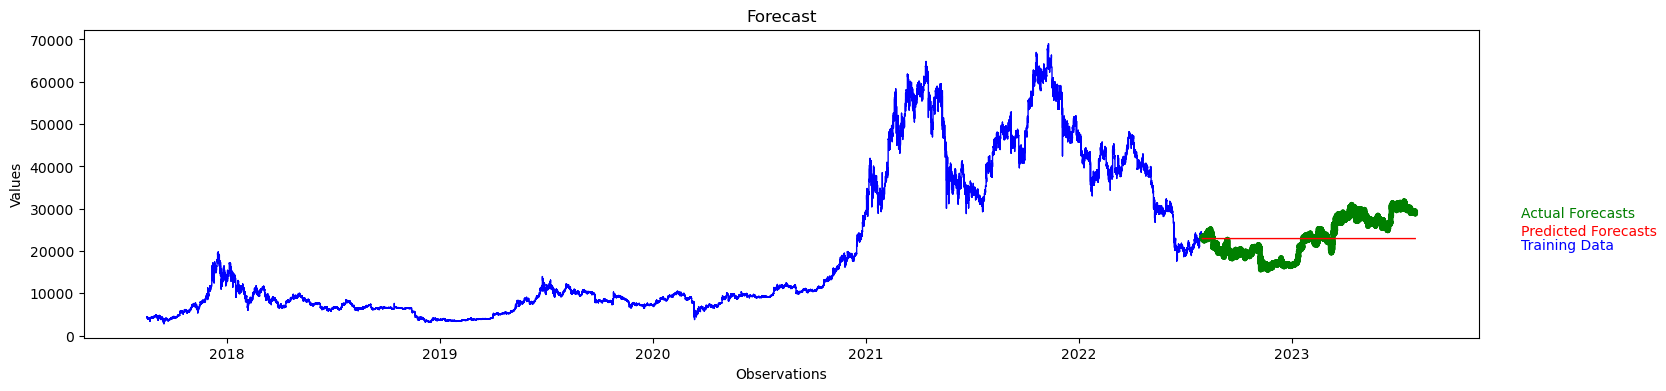

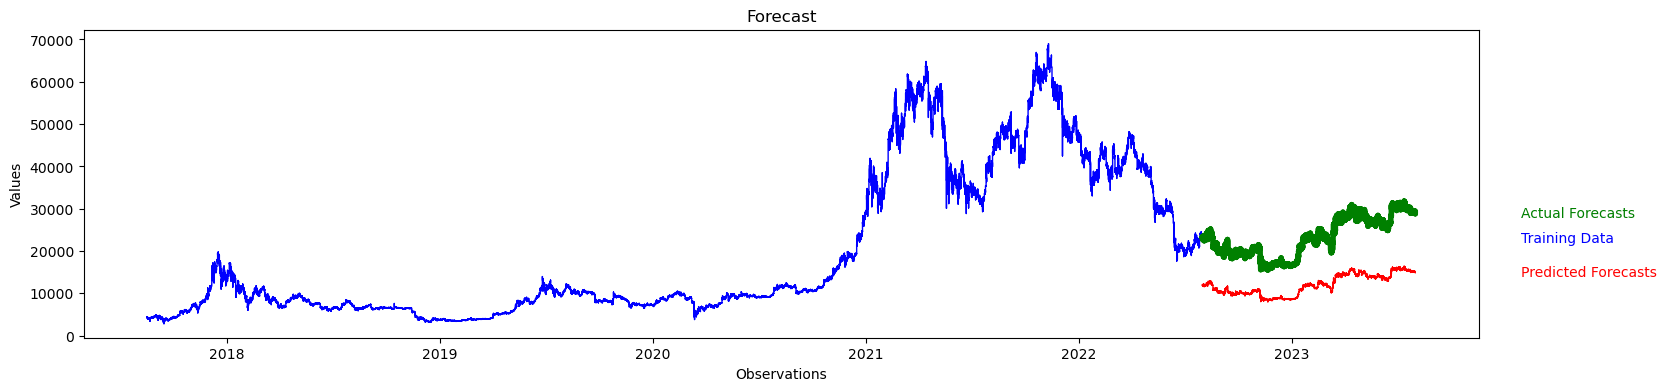

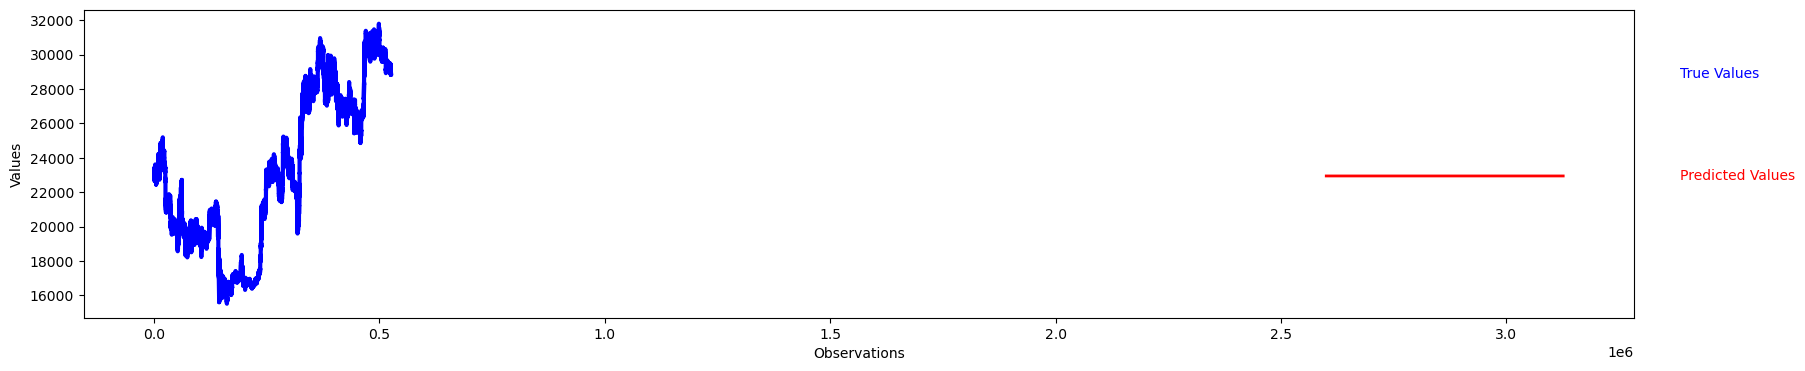

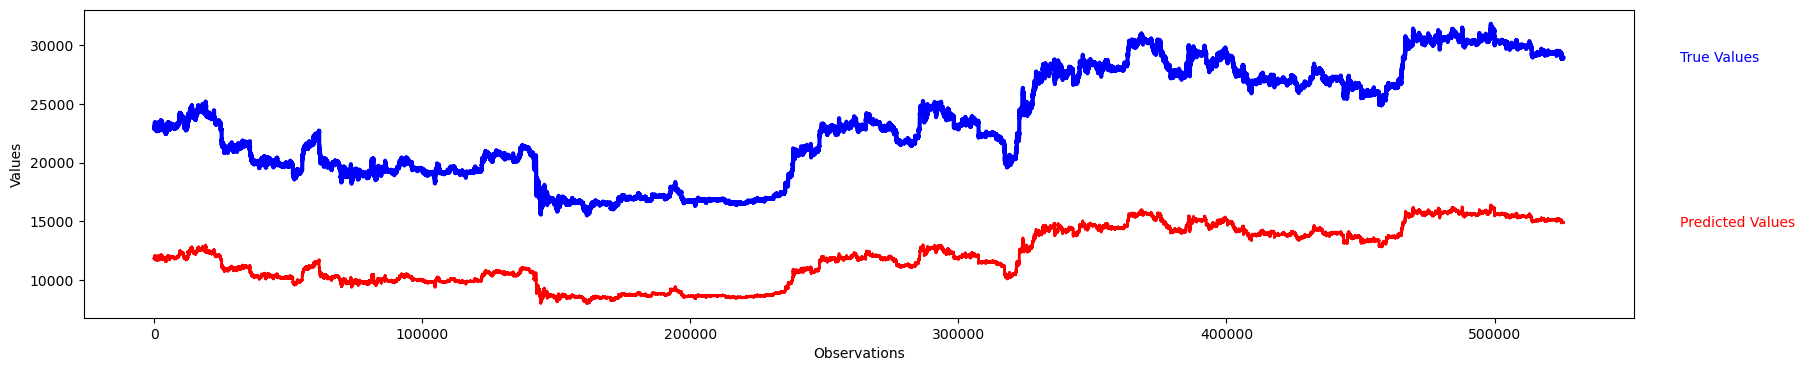

In [26]:
EvaluationMetric.plot_forecast(train_df, test_df, arima_predictions_no_retrain, False)
EvaluationMetric.plot_forecast(train_df, test_df, arima_predictions_retrain, False)
EvaluationMetric.plot_predictions(test_df, arima_predictions_no_retrain)
EvaluationMetric.plot_predictions(test_df, arima_predictions_retrain)

### Follow-up
- What can we determine from this?
    - Raw TS
        - `RW`
        - `ARIMA-no-retrain`
        - `ARIMA-retrain`